## Figure 9: Orbit determination

##### Ratio of recovered uncertainties of the semi-major axis between the scenario with and without diversity in observations for nine asteroids taken from section 2.3 in the manuscript as seen in steps 5 and 8, and their dependence on asteroid distances from Earth as seen in step 6. The uncertainty were derived from Find_Orb. In the manuscript, we present a table 4 with all the results from Find_Orb, such as the semi-major axis with uncertainties for the two cases, the average distance, and the percentage difference between observations with diversity and without diversity. 

##### Step 1: Here we import all the packages used throughout the notebook:

In [69]:
# For numerical arrays and dataframes.
import numpy as np
import pandas as pd

# For handling plotting and axis formatting 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# For custom subplot layouts
from matplotlib.gridspec import GridSpec

# Tools for fitting functions to data
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

# For file handling and regular expressions
import re
import os
from pathlib import Path

# Access to trigonometric functions and constants
import math

# Used to manually create custom legend entries
from matplotlib.lines import Line2D

# when working with dates and times, including parsing and formatting timestamps
from datetime import datetime

# high-level file operations such as copying, moving, and deleting files or directories
import shutil

##### Step 2: Reading and Extracting the raw data of the nine asteroids from the NASA JPL Horizon System

In [70]:
# txt_files_folder  = where the Horizons .txt files are stored
# csv_output_folder = where the converted .csv files will be saved
txt_files_folder  = '/hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/'
csv_output_folder = '/hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs'

# os.makedirs() creates the folder if missing. 
if not os.path.exists(csv_output_folder):
    os.makedirs(csv_output_folder)
    print(f"Created output folder: {csv_output_folder}")

# In the list, the following are column headers in the DataFrame. The blanks denoted by '' correspond to columns that are not required in the analysis. 
# A pandas.DataFrame is created using the specified column names.
columns = ['Date__(UT)__HR:MN', '', '', ' R.A._(ICRF)', 'DEC__(ICRF)', 'delta', 'deldot', '', ' RA_3sigma', 'DEC_3sigma']

# Lists every item in the folder. Each file will be examined to see whether it should be processed.  
for file_name in os.listdir(txt_files_folder):

    # The file to process must have an extension of .txt
    if file_name.endswith('.txt'):
        file_path = os.path.join(txt_files_folder, file_name)

        # We only want to extract the code between “SOE” (Start of Ephemeris) and “EOE” (End of Ephemeris), since they contain the ephemeris data. 
        start_marker = "$$SOE"
        end_marker = "$$EOE"
        
        # This list will store the ephemeris rows after extraction.
        data_lines = []
        
        try:
            # open: opens the file in read mode ('r'). 
            # with: ensures that the file is closed properly after reading.
            with open(file_path, 'r') as file:
                
                # is_data: A Boolean flag. It indicates if an ephemeris row of data is within the appropriate data section row.
                is_data = False
                
                # Iterates through every line 
                for line in file:

                    # When a row of lines contains SOE (the start marker), 'is_data' is set to True. Beyond this line, data will be captured.
                    if start_marker in line:
                        is_data = True
                        
                    # When a row of lines contains EOE (the end marker), 'is_data' is set to False. Beyond this line, data will not be captured.
                    elif end_marker in line:
                        is_data = False
                        
                    # In the case that neither marker is found, and 'is_data' is true, it means that data capturing is still on-going, and hasn't reached EOE. 
                    elif is_data:
                        
                        # .strip() removes whitespaces and appends lines to data_lines.
                        data_lines.append(line.strip())
            
            # Each line of ephemeris data that is captured is split at the commas to form string values that are in the form of rows and columns (lists of lists) for the csv. 
            data = [line.split(",") for line in data_lines]

            # max_columns searches for the longest row and its length.
            max_columns = max(len(row) for row in data)
            
            # Shorter rows are padded with empty strings at locations that do not have data, to represent the same length as the longest row. This ensures that the DataFrame is created without misaligned columns.
            data = [row + [''] * (max_columns - len(row)) for row in data]

            # Convert the rows and columns into a pandas.DataFrame. 
            df = pd.DataFrame(data, columns=columns[:max_columns])

            # os.path.basename(file_path): extracts the filename
            # os.path.splitext(...)[0]:    removes the file extension (.txt)
            base_name = os.path.splitext(file_name)[0]

            # A new .csv is appended to the newly created file.
            csv_file_path = os.path.join(csv_output_folder, f'{base_name}.csv')

            # The DataFrame is exported to a .csv file. 
            # index=False: prevents the DataFrame's index from being written as an extra column.
            df.to_csv(csv_file_path, index=False)
            print(f"CSV file saved: {csv_file_path}")

        # If a file is missing or unreadable → a friendly message is printed.
        # If something unexpected goes wrong → the specific error is printed.
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/2024 ON (6 days but 4th day with NO diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/2024 SJ (6 days but 4th day with diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/2014 GL1 (6 days but 4th day with diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/2014 GL1 (6 days but 4th day with NO diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/2024 ON (6 days but 4th day with diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/2024 RN15 (6 days but 4th day with NO diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/2024 RJ16 (6 days but 4th day with NO diversity).csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/2024 RO2 (6 days but 4

##### Step 3: Convert the data to .obs file for inputting into Find_Orb

In [71]:
# Create subfolder for .obs files
formatted_folder = os.path.join(csv_output_folder, "formatted_obs")

# make the folder if it doesn't exist.
os.makedirs(formatted_folder, exist_ok=True)

# Function to convert every row into MPC .obs format. 
def format_mpc(date_str, ra, dec, observatory='807'):
    
    # Convert the Horizons timestamp string into a datetime object
    dt = datetime.strptime(date_str.strip(), "%Y-%b-%d %H:%M:%S.%f")

    # --------------------- The date and time
    
    # Convert time-of-day into fractional day for MPC's YYYY MM DD.ddddd format
    day_fraction = dt.day + (dt.hour + dt.minute / 60 + dt.second / 3600 + dt.microsecond / 1e6 / 3600) / 24
    
    # Format date for MPC: must begin with "C" and contain year, month, and fractional day
    date_fmt = f"C{dt.year:04d} {dt.month:02d} {day_fraction:08.5f}"

    # --------------------- RA
    
    # Break RA string into hours, minutes, seconds
    ra_h, ra_m, ra_s = ra.strip().split()

    # Format RA into MPC-required fixed-width columns
    ra_fmt = f"{int(ra_h):02d} {int(ra_m):02d} {float(ra_s):05.2f}"

    # --------------------- DEC
    
    # Determine if DEC is positive (+) or negative (-)
    sign = '+' if '+' in dec else '-'

    # Remove sign and split into degrees, arcminutes, arcseconds
    d, m, s = dec.replace('+','').replace('-','').split()

    # Format DEC into MPC fixed-width format with sign
    dec_fmt = f"{sign}{int(d):02d} {int(m):02d} {float(s):04.1f}"

    # --------------------- Final 80-column MPC formatted ephemeris
    
    # Construct the final MPC observation line with proper spacing + observatory code
    return f"             {date_fmt} {ra_fmt} {dec_fmt}                      {observatory}"

# Convert every csv inside csv_output_folder into a .obs file
for file_name in os.listdir(csv_output_folder):

    # Only process csv files
    if file_name.endswith('.csv'):

        try:

            # Full path to CSV
            csv_path = os.path.join(csv_output_folder, file_name)

            # Read CSV into DataFrame
            df = pd.read_csv(csv_path)

            # Remove extra spaces from column names
            df.columns = df.columns.str.strip()

            # Convert each row into an MPC-formatted line using the formatter defined above
            lines = [
                format_mpc(row['Date__(UT)__HR:MN'], row['R.A._(ICRF)'], row['DEC__(ICRF)'])
                
                # Loop over each observation
                for _, row in df.iterrows()]

            # Create output file name with .obs extension
            obs_path = os.path.join(formatted_folder, f"{os.path.splitext(file_name)[0]}.obs")
            
            # Write all MPC lines into the .obs output file
            with open(obs_path, 'w') as f:
                f.write("\n".join(lines) + "\n")
            print(f" MPC file saved: {obs_path}")

        # Catch any errors in processing
        except Exception as e:
            print(f" Error in {file_name}: {e}")

 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/formatted_obs/2024 RN15 (6 days but 4th day with NO diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/formatted_obs/2024 RJ16 (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/formatted_obs/2022 QV1 (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/formatted_obs/2014 GL1 (6 days but 4th day with NO diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/formatted_obs/2024 RN15 (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/formatted_obs/2024 SJ (6 days but 4th day with diversity).obs
 MPC file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 9, Table 4/mpc_obs/formatted_obs/2024 RO2 (6 days but 4th day with diversity).ob

##### Step 4: Print all the .obs files for all 9 asteroids. 

In [72]:
for file_name in sorted(os.listdir(formatted_folder)):
    if file_name.endswith('.obs'):
        print(f"\n📄 {file_name}")
        
        with open(os.path.join(formatted_folder, file_name), 'r') as f:
            print(f.read())


📄 2014 GL1 (6 days but 4th day with NO diversity).obs
             C2024 08 31.00000 16 40 26.40 -29 14 30.1                      807
             C2024 09 01.00000 16 40 36.45 -29 10 03.5                      807
             C2024 09 02.00000 16 40 49.50 -29 05 43.9                      807
             C2024 09 03.00000 16 41 05.48 -29 01 31.1                      807
             C2024 09 04.00000 16 41 24.34 -28 57 25.0                      807
             C2024 09 05.00000 16 41 46.03 -28 53 25.6                      807


📄 2014 GL1 (6 days but 4th day with diversity).obs
             C2024 08 31.00000 16 40 26.40 -29 14 30.1                      807
             C2024 09 01.00000 16 40 36.45 -29 10 03.5                      807
             C2024 09 02.00000 16 40 49.50 -29 05 43.9                      807
             C2024 09 03.95833 16 41 23.65 -28 57 35.4                      807
             C2024 09 04.08333 16 41 25.80 -28 57 03.7                      807
            

## **Uncertainties in the semi-major axis taken from Find_Orb.**

##### Step 5: Results of the semi-major axis uncertainties for each of the nine asteroids.

In [73]:
# We have attached a .pdf file in 'Folder 9, Table 4' repository that shows the results of each asteroid from Find_Orb for the two observational cases: observations with diversity and non-diversity. 

# --------------------- Without diversity: Uncertainties in the semi-major axis. ---------------------

uncertainty_a_no_diversity = [0.57,      0.0412,    0.0657,      0.141,       0.0403,     0.695,  0.237, 0.0558, 2.96]

# --------------------- With diversity: Uncertainties in the semi-major axis. ---------------------

uncertainty_a_diversity    = [0.0223,    0.00487,   0.0105,      0.0328,      0.0172,     0.0624, 0.125, 0.084,  9.28]

# --------------------- Asteroid names. ---------------------

asteroids =                  ["2024 ON", "2024 SJ", "2024 RN15", "2024 RJ16", "2024 RO2", "2022 QV1", "2024 YR4", "2014 GL1", "Ceres"]

##### Step 6: The disatance average for each of the nine asteroids.

In [74]:
# Helper function (keeps things clean)
def average_of_two_means(diversity, no_diversity):
    avg_div = sum(diversity)    / len(diversity)
    avg_no  = sum(no_diversity) / len(no_diversity)
    return (avg_div + avg_no)   / 2


# 2024 ON
ON_NO_diversity   = [0.08574, 0.08096, 0.07616, 0.07134, 0.06652, 0.06168]
ON__diversity     = [0.08799, 0.08308, 0.07815, 0.06846, 0.06785, 0.06725]
ON_avg = average_of_two_means(ON_NO_diversity, ON__diversity)

# 2024 SJ
SJ_NO_diversity  = [0.10970, 0.10739, 0.10510, 0.10282, 0.10056, 0.09833]
SJ_diversity     = [0.10970, 0.10739, 0.10510, 0.10066, 0.10038, 0.10010]
SJ_avg = average_of_two_means(SJ_NO_diversity, SJ_diversity)

# 2024 RN15
RN15_NO_diversity= [0.14412, 0.13900, 0.13395, 0.12896, 0.12404, 0.11918]
RN15_diversity   = [0.14507, 0.13992, 0.13483, 0.12507, 0.12444, 0.12381]
RN15_avg = average_of_two_means(RN15_NO_diversity, RN15_diversity)

# 2024 RJ16
RJ16_NO_diversity= [0.15486, 0.14994, 0.14510, 0.14033, 0.13563, 0.13100]
RJ16_diversity   = [0.15515, 0.15022, 0.14537, 0.13609, 0.13548, 0.13490]
RJ16_avg = average_of_two_means(RJ16_NO_diversity, RJ16_diversity)

# 2024 RO2
RO2_NO_diversity = [0.18152, 0.17527, 0.16909, 0.16297, 0.15691, 0.15091]
RO2_diversity    = [0.18172, 0.17547, 0.16928, 0.15736, 0.15658, 0.15582]
RO2_avg = average_of_two_means(RO2_NO_diversity, RO2_diversity)

# 2022 QV1
QV1_NO_diversity = [0.53977, 0.54038, 0.54097, 0.54155, 0.54212, 0.54267]
QV1_diversity    = [0.49954, 0.50011, 0.50067, 0.50171, 0.50178, 0.50187]
QV1_avg = average_of_two_means(QV1_NO_diversity, QV1_diversity)

# 2024 YR4
YR4_NO_diversity = [0.63488, 0.63348, 0.63211, 0.63078, 0.62946, 0.62816]
YR4_diversity    = [0.63964, 0.63830, 0.63700, 0.63452, 0.63437, 0.63423]
YR4_avg = average_of_two_means(YR4_NO_diversity, YR4_diversity)

# 2014 GL1
GL1_NO_diversity = [0.98475, 0.98820, 0.9916,  0.9949,  0.9980,  1.0012 ]
GL1_diversity    = [0.98507, 0.98850, 0.9919,  0.9982,  0.9986,  0.9990 ]
GL1_avg = average_of_two_means(GL1_NO_diversity, GL1_diversity)

# Ceres
Ceres_NO_diversity= [2.3213, 2.3329, 2.3445, 2.3563, 2.3681, 2.3801]
Ceres_diversity   = [2.3672, 2.3734, 2.3796, 2.3921, 2.3929, 2.3938]
Ceres_avg = average_of_two_means(Ceres_NO_diversity, Ceres_diversity)


# Print results (rounded to the first four decimals)
print(f"2024 ON   : {ON_avg:.4f}")
print(f"2024 SJ   : {SJ_avg:.4f}")
print(f"2024 RN15 : {RN15_avg:.4f}")
print(f"2024 RJ16 : {RJ16_avg:.4f}")
print(f"2024 RO2  : {RO2_avg:.4f}")
print(f"2022 QV1  : {QV1_avg:.4f}")
print(f"2024 YR4  : {YR4_avg:.4f}")
print(f"2014 GL1  : {GL1_avg:.4f}")
print(f"Ceres     : {Ceres_avg:.4f}")

# --------------------- Average distance. ---------------------
average_distance =           [0.0746,    0.1039,   0.1319,     0.1428,     0.1661,    0.5211, 0.6339, 0.9933, 2.3669]

2024 ON   : 0.0746
2024 SJ   : 0.1039
2024 RN15 : 0.1319
2024 RJ16 : 0.1428
2024 RO2  : 0.1661
2022 QV1  : 0.5211
2024 YR4  : 0.6339
2014 GL1  : 0.9933
Ceres     : 2.3669


##### Step 7: Uncertainty Difference

In [75]:
uncertainty_a_no_diversity1 = np.array(uncertainty_a_no_diversity)
uncertainty_a_diversity1    = np.array(uncertainty_a_diversity)

uncertainty_difference = abs((uncertainty_a_diversity1 - uncertainty_a_no_diversity1)/uncertainty_a_no_diversity1)*100
print(uncertainty_difference)

[ 96.0877193   88.17961165  84.01826484  76.73758865  57.32009926
  91.02158273  47.25738397  50.53763441 213.51351351]


##### Step 8: Ratio of the semi-major axis uncertainties = (diversity/without diversity). 

In [76]:
uncertainty_ratio_a = np.array(uncertainty_a_diversity) / np.array(uncertainty_a_no_diversity)
print(uncertainty_ratio_a)

[0.03912281 0.11820388 0.15981735 0.23262411 0.42679901 0.08978417
 0.52742616 1.50537634 3.13513514]


##### Step 9: Plot the results

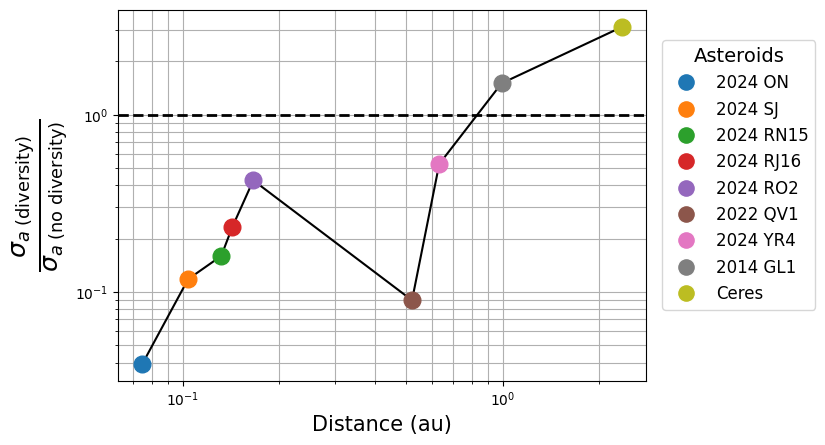

In [77]:
colors = plt.cm.tab10.colors
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid(True, which='both', axis='both')

ax1.set_xlabel('Distance (au)', fontsize=15)
ax1.set_ylabel(r'$\frac{\sigma_{a\ \mathrm{(diversity)}}}{\sigma_{a\ \mathrm{(no\ diversity)}}}$', fontsize=26)

ax1.plot(average_distance, uncertainty_ratio_a, '-', color='black', alpha=1)
for i in range(len(asteroids)):
    ax1.plot(average_distance[i], uncertainty_ratio_a[i], 'o', color=colors[i % len(colors)], markersize=12)
    
ax1.axhline(1, color='black', linestyle='--', linewidth=2)

asteroid_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=asteroids[i],
               markerfacecolor=colors[i % len(colors)], markersize=13)
    for i in range(len(asteroids))]
fig.legend(handles=asteroid_handles, title="Asteroids",
           loc='center left', bbox_to_anchor=(0.82, 0.55),
           fontsize=12, title_fontsize=14)

fig.tight_layout()
plt.subplots_adjust(left=0.15, right=0.81, top=0.88)
plt.savefig("uncertainty_ratio_plot.png", dpi=300, bbox_inches='tight')
plt.show()

##### **Summary:** 

##### In this notebook, we process Horizons-generated ephemerides for nine different asteroids taken from section 2.3 in the manuscript to evaluate how diversity and non-diversity observations affect orbit determination. For each asteroid in the two cases, the raw Horizons .txt file is converted into an MPC-formatted .obs file for proper input into Find_Orb. In total, each asteroid has two files, one for each observational case, totalling 18 files. 

##### Once the .obs files are generated, we process the file into Find_Orb, and the results of the orbit determination are attached in a .pdf in the GitHub folder 'Figure 9, Table 4'. From each orbit solution, we extract the formal semi-major axis uncertainty returned by Find_Orb, which quantifies how much the inclusion of diversity improves (or does not improve) the orbit solution. Finally, we plot this ratio as a function of each asteroid’s average topocentric parallax distance. 

##### Overall, this workflow demonstrates that close-approaching NEOs show the greatest improvement in semi-major axis precision when diversity is included, while distant main-belt asteroids experience minimal gain. This validates the role of observational diversity in strengthening early orbit determination for near-Earth objects for planetary defense.